In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import SGD ,AdamW

from datasets import load_dataset, load_metric

import matplotlib.pyplot as plt

import json


In [2]:
import utils_generic as generic
import multitask_dep as mt
import model_confs as confs
import train_dep as train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(27)
tasks = ['to','as','about']

In [4]:
model_conf = confs.distilbert_conf
encoding_type = 'pos'

# Datos ConvAI

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab = mt.Vocabulary(data['train'],encoding_type)

In [7]:
convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset_with_dependencies(convai_train,['about','to','as'],vocab,model_conf) 
convai_val_token = generic.tokenize_dataset_with_dependencies(convai_val,['about','to','as'],vocab,model_conf) 

In [8]:
convai_train_dataset = mt.DatasetMultitaskDep(convai_train_token,tasks,eval=False)
convai_val_dataset = mt.DatasetMultitaskDep(convai_val_token,tasks,eval=False)

# Datos md_gender

In [9]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [10]:
md_tokenized = generic.tokenize_dataset_with_dependencies(md_data,['about','to','as'],vocab,model_conf) 
md_dataset = mt.DatasetMultitaskDep(md_tokenized,tasks,eval=True)

# Creación dataloaders

In [11]:
dl_train =DataLoader(convai_train_dataset,batch_size=128,shuffle=True,collate_fn=mt.collate_fn)
dl_val =DataLoader(convai_val_dataset,batch_size=128,shuffle=True,collate_fn=mt.collate_fn)
dl_eval = DataLoader(md_dataset,batch_size=128,shuffle=False,collate_fn=mt.collate_fn)

# Modelo multitask

In [12]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
save_path='m1_distilbert_multi_pos_adam'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.0503949462744417 	 Validation loss: 2.0122879581936335 	 
  1%|          | 574/57400 [02:20<3:57:42,  3.98it/s]
Epoch 2 	 Training loss: 1.9897300742229103 	 Validation loss: 1.992592154923132 	 
  2%|▏         | 1148/57400 [04:44<3:53:13,  4.02it/s]
Epoch 3 	 Training loss: 1.9759552318875382 	 Validation loss: 1.9884565583730147 	 
  3%|▎         | 1722/57400 [07:07<3:52:21,  3.99it/s]
Epoch 4 	 Training loss: 1.9749800648008073 	 Validation loss: 1.9820868261789872 	 
  4%|▍         | 2296/57400 [09:32<3:38:55,  4.20it/s]
Epoch 5 	 Training loss: 1.9656986274370334 	 Validation loss: 1.9726766832804277 	 
  5%|▌         | 2870/57400 [11:55<3:40:30,  4.12it/s]
Epoch 6 	 Training loss: 1.9656861085924953 	 Validation loss: 1.9790341591430922 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [14:19<3:36:03,  4.16it/s]
Epoch 7 	 Training loss: 1.9592697632852747 	 Validation loss: 1.9722128318527998 	 
  7%|▋         | 4018/57400 [16:42<3:43:35,  3.9

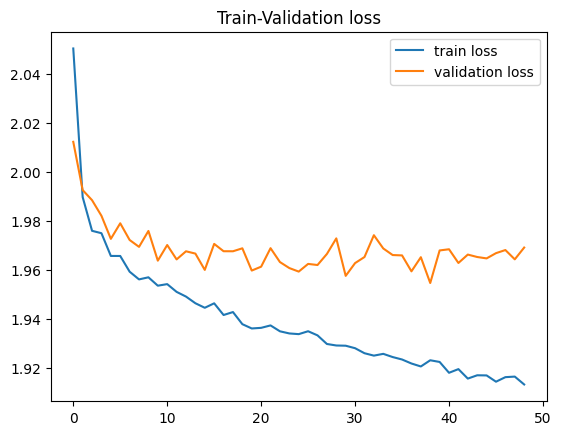

In [13]:
learning_rate = 1e-6
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
num_epochs = 100
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path)

In [14]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))

print("Accuracy evaluando en todas las etiquetas")
print(train.eval_function_multi(model,dl_eval,tasks))
print("Accuracy evaluando en etiquetas female")
print(train.eval_function_multi(model,dl_eval,tasks,'female'))
print("Accuracy evaluando en etiquetas male")
print(train.eval_function_multi(model,dl_eval,tasks,'male'))

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Accuracy evaluando en todas las etiquetas
{'to': 0.6792929292929293, 'as': 0.7262059973924381, 'about': 0.8214285714285714}
Accuracy evaluando en etiquetas female
{'to': 0.6614173228346457, 'as': 0.7466307277628033, 'about': 0.805}
Accuracy evaluando en etiquetas male
{'to': 0.6958637469586375, 'as': 0.7070707070707071, 'about': 0.8385416666666666}
